## Exploratory Data Analysis: Speech Emotion Recognition on EmoDB



#### Libraries

In [43]:
import pandas as pd
import numpy as np
import librosa
import os
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches

#### Loading Data

In [57]:
EmoDB_folder_path = "EmoDB/wav"

emotion_map = {
    'W': 'anger',      # Wut
    'L': 'boredom',    # Langeweile
    'E': 'disgust',    # Ekel
    'A': 'fear',       # Angst
    'F': 'happiness',  # Freude
    'T': 'sadness',    # Traurigkeit
    'N': 'neutral'     # Neutral
}

# Initialize data storage
audio_data = []

# Loop through all WAV files
for file in os.listdir(EmoDB_folder_path):
    if file.endswith(".wav"):
        path = os.path.join(EmoDB_folder_path, file)
        try:
            y, sr = librosa.load(path, sr=None)
            duration = librosa.get_duration(y=y, sr=sr)
            emotion_code = file[5]  # 6th character in filename
            emotion = emotion_map.get(emotion_code, "unknown")
            audio_data.append({
                "filename": file,
                "emotion": emotion,
                "duration": duration,
                "sample_rate": sr
            })
        except Exception as e:
            print(f"Error processing {file}: {e}")

# Create DataFrame
df = pd.DataFrame(audio_data)

# Show first rows
print(df.head())

      filename    emotion  duration  sample_rate
0  03a01Fa.wav  happiness  1.898250        16000
1  03a01Nc.wav    neutral  1.611250        16000
2  03a01Wa.wav      anger  1.877813        16000
3  03a02Fc.wav  happiness  2.006250        16000
4  03a02Nc.wav    neutral  1.439812        16000


#### Overview Information

In [ ]:
# Number of audio files
print("Total audio files:", len(df))

# Check Sampling Rate Consistency
print("Sampling rate counts:", df['sample_rate'].value_counts().to_dict())

# Check 'unknown' Emotion
print("Number of 'unknown' Emotion Audio: ", sum(df['emotion'] == 'unknown'))

Total audio files: 535
Sampling rate counts: {16000: 535}
Number of 'unknown' Emotion Audio:  0



&rarr; All 535 audio files have a consistent sampling rate of 16,000 Hz.  
&rarr; There are 0 audio samples labeled as 'unknown', indicating that the emotion labels are complete and well-annotated.

In [5]:
emotion_count = df['emotion'].value_counts().to_dict()

print("Samples per emotion:")
for k, v in emotion_count.items():
    print(k, v)

Samples per emotion:
anger 127
boredom 81
neutral 79
happiness 71
fear 69
sadness 62
disgust 46


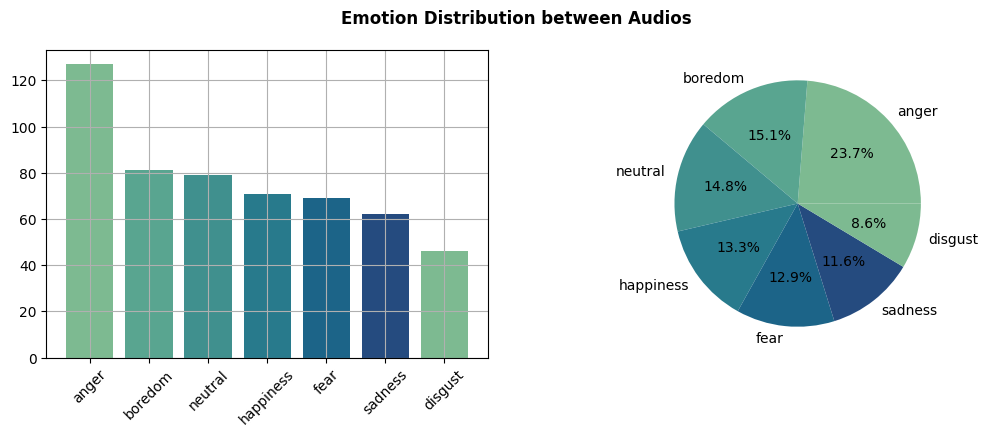

In [83]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.55, 4))
colors = sns.color_palette('crest')


ax1.bar(emotion_count.keys(), emotion_count.values(), color=colors)
ax1.tick_params(axis='x', labelrotation=45)
ax1.grid(True)  

ax2.pie(emotion_count.values(), labels=emotion_count.keys(), autopct='%1.1f%%', colors=colors)
ax2.grid(True)


plt.suptitle('Emotion Distribution between Audios', fontweight='bold')
plt.show()

**Note**: `anger` is the most frequent emotion, while `disgust` is the least.  
&rarr; This class imbalance should be addressed during model development (e.g., with class weighting or data augmentation).

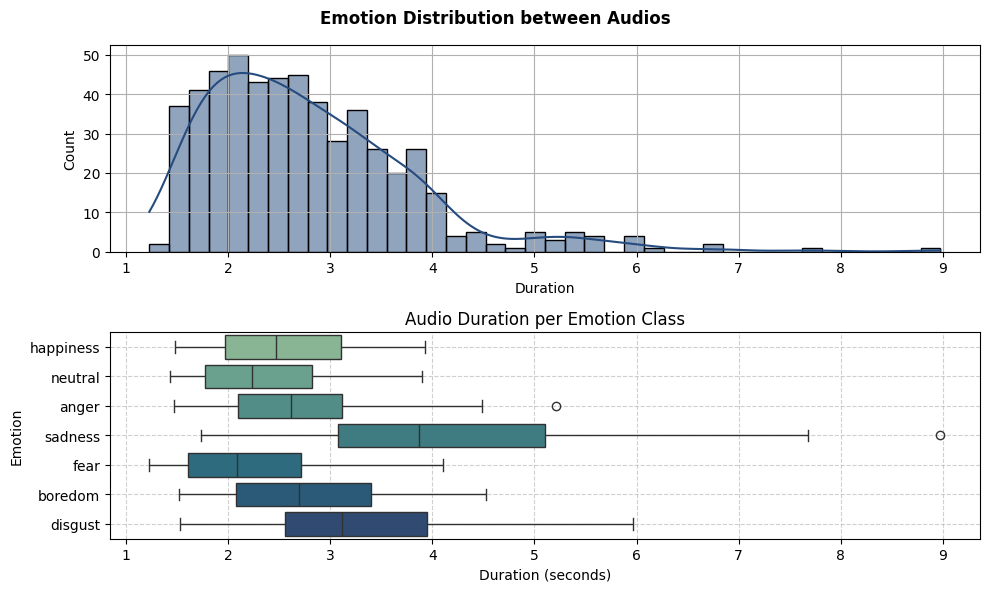

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))
colors = sns.color_palette('crest')

sns.histplot(df['duration'], bins=40, kde=True, ax=ax1, edgecolor='black', color=colors[5])
ax1.set_xlabel('Duration')
ax1.grid(True)  

sns.boxplot(data=df, x='duration', y='emotion', hue='emotion', palette='crest', legend=False, vert=False, ax=ax2)
ax2.set_title("Audio Duration per Emotion Class", fontdict={})
ax2.set_xlabel("Duration (seconds)")
ax2.set_ylabel("Emotion")
ax2.grid(True, linestyle='--', alpha=0.6)

plt.suptitle('Emotion Distribution between Audios', fontweight='bold')

plt.tight_layout()
plt.show()

- Most audio samples range between **2 to 4 seconds**, though some longer outliers exist (e.g., sadness up to ~9s).
- `sadness` has the **widest duration spread**, indicating more variability in expression length.
- `anger`, `neutral`, and `happiness` have relatively consistent durations with compact interquartile ranges.
- `disgust` and `boredom` tend to have shorter and more consistent audio durations.

> This analysis suggests that emotion types may affect how long a person speaks, which could be a useful signal for modeling or preprocessing.

#### Waveform Visualization

In [94]:
emotion_samples = {}

for emotion in df['emotion'].unique():
    sample_row = df[df['emotion'] == emotion].iloc[0]
    emotion_samples[emotion] = sample_row['filename']

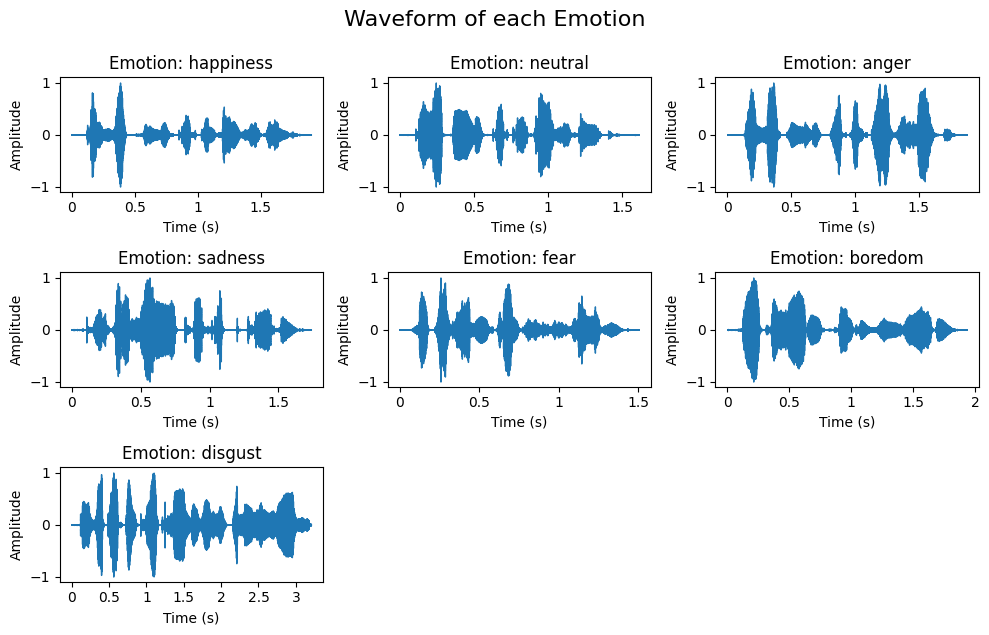

In [100]:
plt.figure(figsize=(10, 6))

for idx, (emotion, fname) in enumerate(emotion_samples.items()):
    file_path = os.path.join(EmoDB_folder_path, fname)
    y, sr = librosa.load(file_path, sr=None)

    plt.subplot(3, 3, idx + 1)
    librosa.display.waveshow(y, sr=sr)
    plt.title(f"Emotion: {emotion}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")

plt.tight_layout()
plt.suptitle("Waveform of each Emotion", fontsize=16, y=1.05)
plt.show()

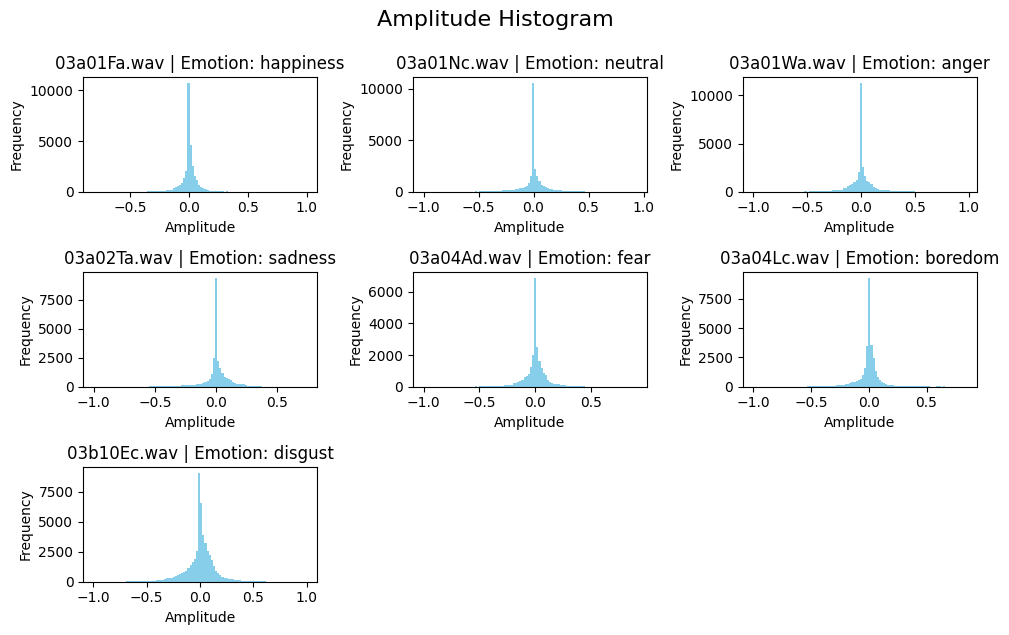

In [101]:
plt.figure(figsize=(10, 6))

for idx, (emotion, fname) in enumerate(emotion_samples.items()):
    file_path = os.path.join(EmoDB_folder_path, fname)
    y, sr = librosa.load(file_path, sr=None)

    plt.subplot(3, 3, idx + 1)
    plt.hist(y, bins=100, color='skyblue')
    plt.title(f"{fname} | Emotion: {emotion}")
    plt.xlabel("Amplitude")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.suptitle("Amplitude Histogram", fontsize=16, y=1.05)
plt.show()



#### Spectrogram

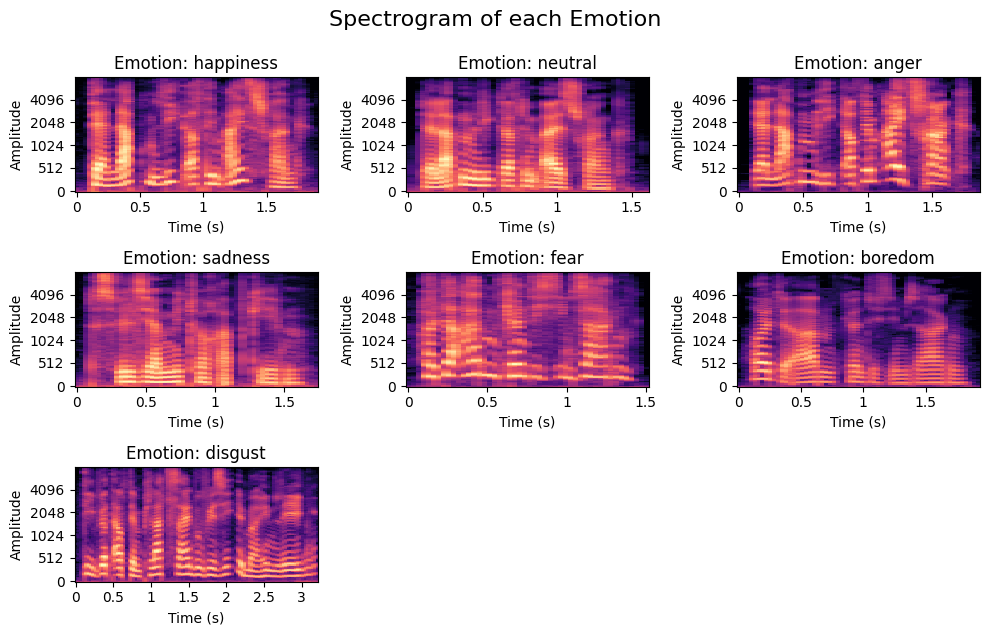

In [109]:
plt.figure(figsize=(10, 6))

for idx, (emotion, fname) in enumerate(emotion_samples.items()):
    file_path = os.path.join(EmoDB_folder_path, fname)
    y, sr = librosa.load(file_path, sr=None)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

    plt.subplot(3, 3, idx + 1)
    librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='mel', fmax=8000, cmap='magma')
    plt.title(f"Emotion: {emotion}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")

plt.tight_layout()
plt.suptitle("Spectrogram of each Emotion", fontsize=16, y=1.05)
plt.show()

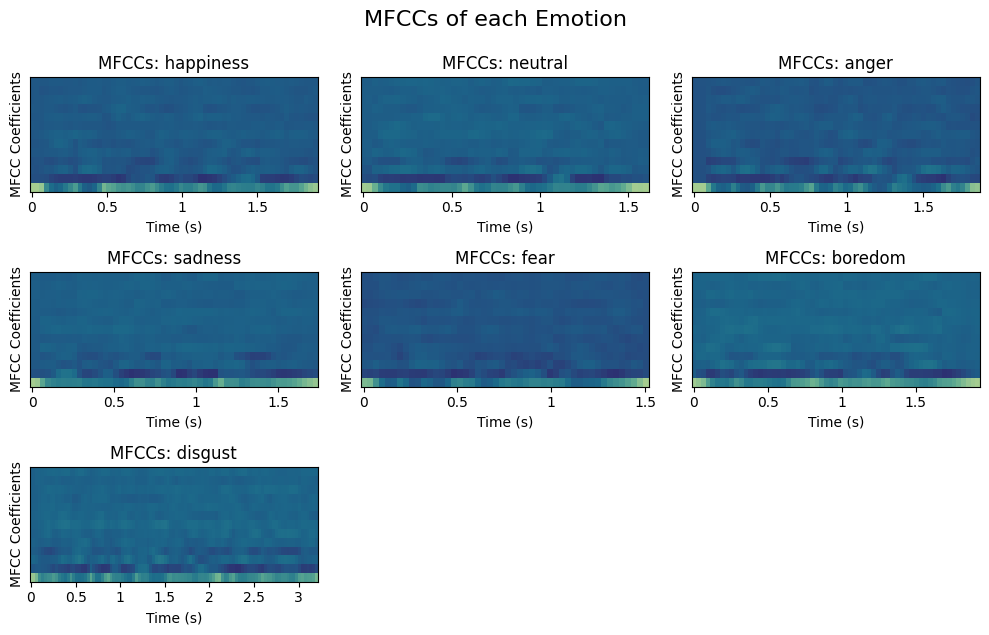

In [111]:
plt.figure(figsize=(10, 6))

for idx, (emotion, fname) in enumerate(emotion_samples.items()):
    file_path = os.path.join(EmoDB_folder_path, fname)
    y, sr = librosa.load(file_path, sr=None)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

    plt.subplot(3, 3, idx + 1)
    librosa.display.specshow(mfccs, sr=sr, x_axis='time', cmap='crest')
    plt.title(f"MFCCs: {emotion}")
    plt.xlabel("Time (s)")
    plt.ylabel("MFCC Coefficients")

plt.tight_layout()
plt.suptitle("MFCCs of each Emotion", fontsize=16, y=1.05)
plt.show()

In [12]:
duration_stats = df.groupby('emotion')['duration'].describe()
print(duration_stats)

           count      mean       std       min       25%       50%       75%  \
emotion                                                                        
anger      127.0  2.640795  0.728803  1.465812  2.090094  2.609875  3.116937   
boredom     81.0  2.778977  0.804450  1.520063  2.074688  2.690562  3.398750   
disgust     46.0  3.352834  1.073298  1.523813  2.552859  3.117188  3.943766   
fear        69.0  2.233377  0.637358  1.225500  1.607938  2.081313  2.711750   
happiness   71.0  2.543967  0.682695  1.481375  1.963625  2.463563  3.106813   
neutral     79.0  2.359236  0.659165  1.430813  1.769750  2.235500  2.822000   
sadness     62.0  4.052895  1.532625  1.735688  3.076344  3.863375  5.102375   

                max  
emotion              
anger      5.213500  
boredom    4.525812  
disgust    5.963813  
fear       4.101375  
happiness  3.930938  
neutral    3.899188  
sadness    8.978250  
